### pbt: Population Based Training

Code to replicate figure 2 of [Population Based Training of Neural Networks, Jaderberg et al](https://arxiv.org/abs/1711.09846)


In [30]:
from __future__ import print_function

import numpy as np

import torch
from torch.optim import SGD
from torch.autograd import Variable
from torch.nn import Parameter

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)


_ = np.random.seed(123)
_ = torch.manual_seed(123)

In [31]:
# Define PBT worker

class Worker():
    
    def __init__(self, theta, h, objective, surrogate_objective, id):
        
        self.theta = theta
        self.h = h
        self.objective = objective
        self.surrogate_objective = surrogate_objective
        self.id = id
        
        self._opt = SGD([theta], lr=0.01)
        self._history = {"theta" : [], "h" : [], "score" : []}
    
    @property
    def history(self):
        return {
            "theta" : np.vstack(self._history['theta']),
            "h"     : np.vstack(self._history['h']),
            "score" : np.array(self._history['score']),
        }
    
    def _log(self):
        self._history['theta'].append(self.theta.data.numpy().copy())
        self._history['h'].append(self.h.data.numpy().copy())
        self._history['score'].append(self.eval())
    
    
    def step(self):
        """ Take an optimization step, given current hyperparemeters and surrogate objective """
        self._log()
        
        self._opt.zero_grad()
        surrogate_loss = -1 * self.surrogate_objective(self.theta, self.h)
        surrogate_loss.backward()
        self._opt.step()
        
    def eval(self):
        """ Evalute actual objective -- eg measure accuracy on the hold-out set """
        
        return self.objective(self.theta).data[0]
    
    def exploit(self, population):
        """ Copy theta from best member of the population """
        
        current_scores = [{
            "id": worker.id,
            "score": worker.eval()
        } for worker in population]
        
        best_worker = sorted(current_scores, key=lambda x: x['score'])[-1]
        
        if best_worker['id'] != self.id:
            self.theta.data.set_(population[best_worker['id']].theta.data.clone())
    
    def explore(self, sd=0.1):
        """ Add normal noise to hyperparameter vector """
        
        self.h.add_(Variable(torch.randn(2) * sd))

In [32]:
def run_experiment(do_explore=False, do_exploit=False, interval=5, n_steps=200):
    
    # Define objective functions
    objective = lambda theta: 1.2 - (theta ** 2).sum()
    surrogate_objective = lambda theta, h: 1.2 - ((h * theta) ** 2).sum()
    
    # Create population
    population = [
        Worker(
            theta=Parameter(torch.FloatTensor([0.9, 0.9])),
            h=Variable(torch.FloatTensor([1.0, 0.0])),
            objective=objective,
            surrogate_objective=surrogate_objective,
            id=0,
        ),
        Worker(
            theta=Parameter(torch.FloatTensor([0.9, 0.9])),
            h=Variable(torch.FloatTensor([0.0, 1.0])),
            objective=objective,
            surrogate_objective=surrogate_objective,
            id=1,
        ),
    ]
    
    # Train
    for step in range(n_steps):
        for worker in population:
            if not (step + 1) % interval:
                
                if do_exploit:
                    worker.exploit(population)
                    
                if do_explore:
                    worker.explore()
            
            worker.step()
    
    return population


In [33]:
# Run experiments w/ various PBT settings
pbt = run_experiment(do_explore=True, do_exploit=True) # Explore and exploit
explore = run_experiment(do_explore=True, do_exploit=False) # Explore only
exploit = run_experiment(do_explore=False, do_exploit=True) # Exploit only
grid = run_experiment(do_explore=False, do_exploit=False) # Independent training runs -- eg, regular grid search

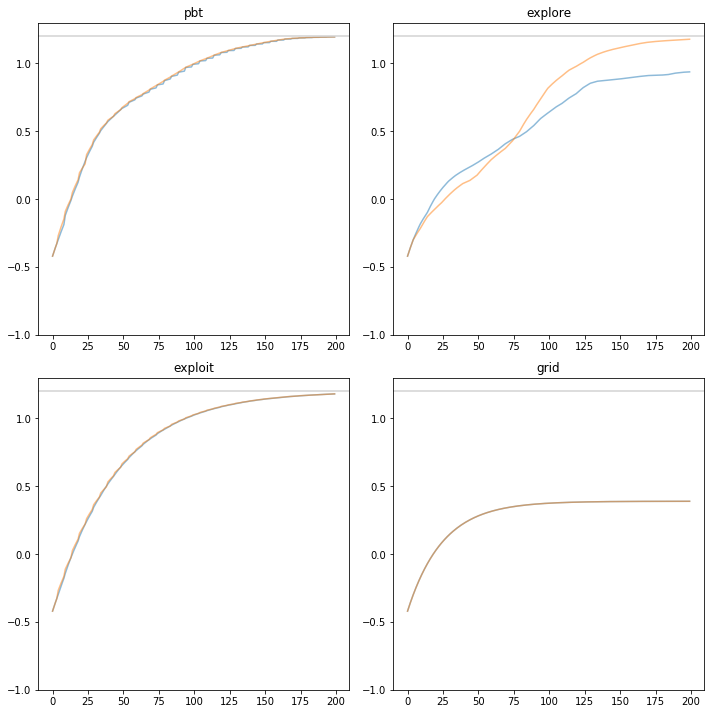

In [34]:
def plot_score(ax, workers, run_name):
    """ Plot performance """
    for worker in workers:
        history = worker.history
        _ = ax.plot(history['score'], label="%s worker %d" % (run_name, worker.id), alpha=0.5)
    
    _ = ax.set_title(run_name)
    _ = ax.set_ylim(-1, 1.3)
    _ = ax.axhline(1.2, c='lightgrey')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
plot_score(ax1, pbt, 'pbt')
plot_score(ax2, explore, 'explore')
plot_score(ax3, exploit, 'exploit')
plot_score(ax4, grid, 'grid')
_ = plt.tight_layout(pad=1)
plt.show()



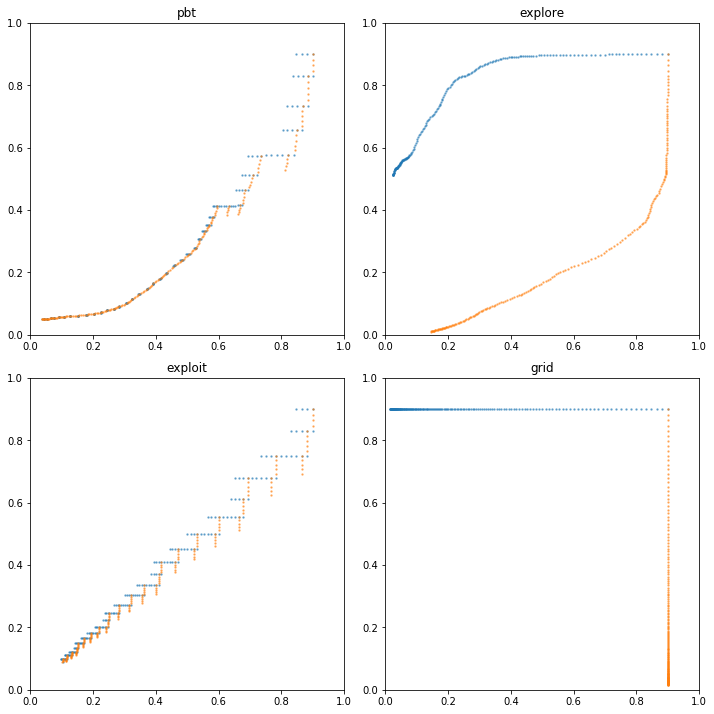

In [36]:
def plot_theta(ax, workers, run_name):
    """ Plot values of theta """
    for worker in workers:
        history = worker.history
        _ = ax.scatter(history['theta'][:,0], history['theta'][:,1], 
            s=2, alpha=0.5, label="%s worker %d" % (run_name, worker.id))
    
    _ = ax.set_title(run_name)
    _ = ax.set_xlim(0, 1)
    _ = ax.set_ylim(0, 1)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
plot_theta(ax1, pbt, 'pbt')
plot_theta(ax2, explore, 'explore')
plot_theta(ax3, exploit, 'exploit')
plot_theta(ax4, grid, 'grid')
_ = plt.tight_layout(pad=1)
plt.show()